In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import ttest_1samp
from scipy.special import gammaln

# Obtain data

In [30]:
symbols = ['^GSPC', 'GOOG', 'MSFT']
symbols = ['^AEX', '^BFX', '^GDAXI']
start_date = '2010-01-01'
start_date = '2000-01-01'
end_date = '2022-04-08'
vPrices = yf.download(symbols, start=start_date, end=end_date)['Close']
vReturns = vPrices.pct_change().dropna() * 100
vNpReturns = np.array(vReturns.transpose())
vTrain = vNpReturns[:,:int(len(vNpReturns[0,:]) * 0.8)]
vTest = vNpReturns[:,int(len(vNpReturns[0,:]) * 0.8):]


[*********************100%***********************]  3 of 3 completed


# CCC Model

### Here We will focuss on the CCC model and its loglikelihood 

In [31]:
def fnGARCHModel(vPar, vData):
    iT = len(vData)
    dOmega = np.exp(vPar[0])
    dAlpha = np.exp(vPar[1])/(1+np.exp(vPar[1]))
    dBeta = np.exp(vPar[2])/(1+np.exp(vPar[2]))

    vSig2 = np.zeros(iT)
    vSig2[0] = np.var(vData)

    for t in range(1,iT):
        vSig2[t] = dOmega + dAlpha * vData[t-1]**2 + dBeta * vSig2[t-1]
    return vSig2

def fnGARCH1Model(vPar, vData):
    iT = len(vData)
    dOmega = vPar[0]
    dAlpha = vPar[1]
    dBeta = vPar[2]

    vSig2 = np.zeros(iT)
    vSig2[0] = np.var(vData)

    for t in range(1,iT):
        vSig2[t] = dOmega + dAlpha * vData[t-1]**2 + dBeta * vSig2[t-1]
    return vSig2

def fnGJR_garch(vPar, vData):

    dOmega = vPar[0]
    dAlpha = vPar[1]
    dBeta = vPar[2]
    dGamma = vPar[3]
    T = len(vData)
    sigma2 = np.zeros(T)
    eps = vData 
    for t in range(0,T):
        if (t) == 0:
            sigma2[0] = np.var(vData)
        else:
            sigma2[t] = dOmega + dAlpha * eps[t-1]**2 + dGamma * eps[t-1]**2 * (eps[t-1]<0) + dBeta * sigma2[t-1]
    
    return sigma2

def fnMinusNormalLogLiklihood(vPar, vData):
    vSig2 = fnGARCHModel(vPar, vData)
    ll = -(1/2) * np.log(2*np.pi) - (1/2) * np.log(vSig2) - (1/2) * vData**2 / vSig2
    ll = np.sum(ll)
    print(ll)
    return -ll

def fnMinusStudentTLogLiklihood(vPar, vData):
    vH = fnGARCHModel(vPar, vData)
    dNu = vPar[3]
    ll = gammaln( (dNu+1)/2 ) - gammaln( dNu/2 ) - 0.5*np.log( (dNu-2)*np.pi*vH ) - 0.5*(dNu+1)*np.log( 1 +  (vData**2)/((dNu-2)*vH) ) 
    ll = np.sum(ll)
    return -ll

def fnMinimiseCCCNormal(vData, vIni):
    results = minimize(fnMinusNormalLogLiklihood, vIni, args= vData, method= "SLSQP")
    results = [np.exp(results.x[0]), np.exp(results.x[1])/(1+np.exp(results.x[1])), np.exp(results.x[2])/(1+np.exp(results.x[2]))]
    return results

def fnMinimiseCCCStudentT(vData, vIni):
    results = minimize(fnMinusStudentTLogLiklihood, vIni, args= vData, method= "SLSQP")
    results = [np.exp(results.x[0]), np.exp(results.x[1])/(1+np.exp(results.x[1])), np.exp(results.x[2])/(1+np.exp(results.x[2]))]
    return results

def fnThreeDimMulti(m1, m2):
    m3 = np.zeros(m1.shape)
    for t in range(m1.shape[2]):
        m3[:,:,t] = m1[:,:,t] @ m2[:,:,t]
    return m3

def fnMultiTimeDimVectorRightTranspose(v1, v2):

    v3 = np.zeros((v1.shape[0], v1.shape[0], v1.shape[1]))
    for t in range(v1.shape[1]):
        v3[:,:,t] = v1[:,t].reshape(3,1) @ v2[:,t].T.reshape(1,3)
    return v3

In [32]:
# One step code

def fnCCCOneStep(vPar, mData):
    iN = mData.shape[0]
    iT = mData.shape[1]
    mDt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mSigt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mR = np.identity(mData.shape[0])
    
    p = 0
    #print(vPar[0:3])
    for i in range(iN):
        mDt[i, i, :] = np.sqrt(fnGARCH1Model(vPar[i*3 : (i+1)*3], mData[i, :]))
        for j in range(iN):
            if i < mData.shape[0] & j > i:
                mR[i,j] = vPar[iN*3 + p]
                mR[j,i] = vPar[iN*3 + p]
                p += 1
    dLL = 0
    for t in range(iT):
        mSigt[:,:,t] = mDt[:,:,t] @ mR @ mDt[:,:,t]
        dLL += iN*np.log(2*np.pi) + np.log(np.linalg.det(mSigt[:,:,t])) + mData[:,t].transpose() @ np.linalg.inv(mSigt[:,:,t]) @ mData[:,t]
    dLL = -(1/2)*dLL
    print(dLL)
    return -dLL 


In [34]:
bounds = [(0.00000001, 20), (0.00000001, 0.99999999), (0.00000001, 0.99999999)]*3 + [(-1, 1)]*3
vFinalResults = [ 3.973e-06,  5.969e-02,  8.988e-01,  4.722e-05,  4.106e-01,
                  2.266e-01,  3.931e-06,  5.064e-02,  9.175e-01,  7.582e-01,
                  8.330e-01,  7.256e-01]

options = {'maxiter': 5000, 'adaptive': True} 
results = minimize(fnCCCOneStep, [0.25, 0.30, 0.30, 0.25, 0.30, 0.30, 0.25, 0.30, 0.30, 0.63, 0.69, 0.75], bounds= bounds, args= vTrain, options=options, method= "Nelder-Mead")
results

-17954.800956065716
-17936.389931828293
-17941.49515087485
-17915.90755717565
-17947.731460538842
-17952.173751839397
-17936.339584483598
-17886.222097468533
-17912.342666047727
-17861.42398561488
-17898.239673576754
-17925.091314546768
-18296.46308719023
-17680.292104724675
-17650.62704004718
-17818.84111845572
-17803.23614243329
-17787.564585001583
-17766.804027536455
-17747.520580436572
-17721.48728680033
-17750.86350179766
-17691.80910364045
-17650.201774255504
-17631.58261378538
-17648.84162714458
-17600.694504324285
-17581.325137356114
-17585.82128306808
-17582.880132631006
-17565.288705232393
-17550.39824754793
-17547.40149775566
-17533.262913889565
-17529.237641375566
-17515.349256173507
-17524.04122889819
-17480.588598161787
-17465.590261598256
-17469.656293792177
-17451.40904802313
-17437.906649477893
-17431.455834832075
-17416.00384076235
-17428.457591152637
-17410.957506383802
-17400.052021637366
-17402.211623669857
-17379.800095458642
-17367.7241467066
-17365.66776260611
-

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 15083.784419770822
             x: [ 1.729e-02  7.274e-02  9.144e-01  2.582e-02  8.612e-02
                  8.910e-01  1.983e-02  6.776e-02  9.207e-01  8.259e-01
                  8.708e-01  7.866e-01]
           nit: 1160
          nfev: 1673
 final_simplex: (array([[ 1.729e-02,  7.274e-02, ...,  8.708e-01,
                         7.866e-01],
                       [ 1.730e-02,  7.273e-02, ...,  8.709e-01,
                         7.867e-01],
                       ...,
                       [ 1.728e-02,  7.272e-02, ...,  8.708e-01,
                         7.866e-01],
                       [ 1.729e-02,  7.268e-02, ...,  8.708e-01,
                         7.866e-01]]), array([ 1.508e+04,  1.508e+04, ...,  1.508e+04,  1.508e+04]))

In [8]:
results.x[0] + results.x[1] + results.x[2] # i = 0 
results.x[3] + results.x[4] + results.x[5] # i = 1

0.4685900174459415

In [24]:
iN = np.shape(vNpReturns)[0]
iT = np.shape(vNpReturns)[1]

mDtElements = np.zeros((iN, iT))
mDtElements[:,0] = np.var(vNpReturns, axis=1)
for d in range(iN):
    for t in range(1,iT):
        mDtElements[d,t] = results.x[d*3] + results.x[d*3 + 1] * np.array(vNpReturns[d,t-1])**2 + results.x[d*3 +2] * mDtElements[d,t-1]
        
mDtElementsSqrt = np.sqrt(mDtElements)
mDt = np.zeros((iN,iN, iT))
for t in range(iT):
    mDt[:,:,t] = np.diag(mDtElementsSqrt[:,t])
#mDt = mDt.to(np.float64)

mE = vNpReturns / np.sqrt(mDtElements)
mCor = np.corrcoef(mE)
mCorMultiDim = np.tile(mCor[:, :, np.newaxis], (1, 1, iT))

mPreSigmat = fnThreeDimMulti(mDt, mCorMultiDim)
mSigmat = fnThreeDimMulti(mPreSigmat, mDt)

In [ ]:
plt.plot(vNpReturns[2,:]**2)
plt.plot(mSigmat[2,2])

In [ ]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(mSigmat[2,2,:], vNpReturns[2,:]**2))

##### Now we we calculate the diagonal matrix of the ccc model called the $D_t$ FOR THE NORMAL DISTRIBUTION

In [ ]:
#n is the number of stocks
iN = np.shape(vNpReturns)[0]
iT = np.shape(vNpReturns)[1]
mEstimates = np.zeros((iN,3))         #standard for any case since we have 3 parameters omega, alpha and beta
for i in range(iN):
    mEstimates[i,:] = fnMinimiseCCCNormal(vNpReturns[i,:], [np.var(vNpReturns[i,:])*(1-0.2-0.2) ,0.2, 0.2])
#mEstimates = np.from_numpy(mEstimates)

mDtElements = np.zeros((iN, iT))
mDtElements[:,0] = np.var(vNpReturns, axis=1)

for t in range(1,iT):
    mDtElements[:,t] = mEstimates[:,0] + mEstimates[:,1] * np.array(vNpReturns[:,t-1])**2 + mEstimates[:,2] * mDtElements[:,t-1]

mDtElementsSqrt = np.sqrt(mDtElements)
mDt = np.zeros((iN,iN, iT))
for t in range(iT):
    mDt[:,:,t] = np.diag(mDtElementsSqrt[:,t])
#mDt = mDt.to(np.float64)

mE = vNpReturns / np.sqrt(mDtElements)
mCor = np.corrcoef(mE)
mCorMultiDim = np.tile(mCor[:, :, np.newaxis], (1, 1, iT))

mPreSigmat = fnThreeDimMulti(mDt, mCorMultiDim)
mSigmat = fnThreeDimMulti(mPreSigmat, mDt)


In [ ]:
mEstimates[0,:]

In [ ]:
plt.plot(vNpReturns[2,:]**2)
# plt.plot(mSigmatStudentT[0,0,:])
plt.plot(mSigmat[2,2,:])
plt.show()

In [ ]:
plt.plot(vNpReturns[1,:]*vNpReturns[2,:])
# plt.plot(mSigmatStudentT[1,2,:])
plt.plot(mSigmat[1,2,:])
plt.show()

In [ ]:
plt.plot(vNpReturns[2,:]**2)
# plt.plot(mSigmatStudentT[2,2,:])
plt.plot(mSigmat[2,2,:])
plt.show()

# DCC Model

In [10]:
def fnDCCOneStep(vPar, mData):
    iN = mData.shape[0]
    iT = mData.shape[1]
    mDt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mSigt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mR = np.identity(mData.shape[0])
    
    p = 0
    for i in range(iN):
        mDt[i, i, :] = np.sqrt(fnGARCH1Model(vPar[i*3 : (i+1)*3], mData[i, :]))
    
    vEpsilon = np.zeros((mDt.shape[1], 1, mDt.shape[2]))
    for t in range(iT):
        vEpsilon[:,:,t] = np.reshape(np.linalg.inv(mDt[:,:,t]) @ mData[:,t], (iN,1)) 
    
    mS = 0
    mEpsilon2 = np.zeros(mSigmat.shape)
    for t in range(iT):
        mS += vEpsilon[:,:,t] @ vEpsilon[:,:,t].transpose()
        mEpsilon2[:,:,t] = vEpsilon[:,:,t] @ vEpsilon[:,:,t].transpose()
    mS = mS / iT

    dA = vPar[iN*3]
    dB = vPar[iN*3 +1 ]
    dW = (1-dA-dB)

    mSig = np.zeros( (vEpsilon.shape[0], vEpsilon.shape[0], vEpsilon.shape[2]) )
    mSig[:,:,0] = np.cov(vEpsilon.reshape(iN,vEpsilon.shape[2]))
    for t in range(1, iT):
        mSig[:,:,t] = dW * mS + dA * (vEpsilon[:,:,t-1] @ vEpsilon[:,:,t-1].transpose()) + dB * mSig[:,:,t-1]
    k = iN
    dLL1 = 0 
    dLL2 = 0
    for t in range(iT):
        mRt = np.linalg.inv(np.sqrt(np.diag(np.diag(mSig[:,:,t])))) @ mSig[:,:,t] @ np.linalg.inv(np.sqrt(np.diag(np.diag(mSig[:,:,t]))))
        dLL1 += k*np.log(2 * np.pi) + 2*np.log(np.linalg.det(mDt[:,:,t])) + (vEpsilon[:,:,t].transpose() @ vEpsilon[:,:,t])
        dLL2 += np.log(np.linalg.det(mRt)) + vEpsilon[:,:,t].transpose() @ np.linalg.inv(mRt) @ vEpsilon[:,:,t] - vEpsilon[:,:,t].transpose()@vEpsilon[:,:,t]
    dLL = -0.5*dLL1 -0.5*dLL2
    print(dLL)
    return -dLL[0][0]

In [28]:
def fnDCCOneStep(vPar, mData):
    iN = mData.shape[0]
    iT = mData.shape[1]
    mDt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mSigt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mR = np.identity(mData.shape[0])
    mS = 0
    mEpsilon2 = np.zeros(mSigmat.shape)
    p = 0
    for i in range(iN):
        mDt[i, i, :] = np.sqrt(fnGARCH1Model(vPar[i*3 : (i+1)*3], mData[i, :]))
    
    vEpsilon = np.zeros((mDt.shape[1], 1, mDt.shape[2]))
    for t in range(iT):
        vEpsilon[:,:,t] = np.reshape(np.linalg.inv(mDt[:,:,t]) @ mData[:,t], (iN,1)) 
        mS += vEpsilon[:,:,t] @ vEpsilon[:,:,t].transpose()
        mEpsilon2[:,:,t] = vEpsilon[:,:,t] @ vEpsilon[:,:,t].transpose()


    mS = mS / iT

    dA = vPar[iN*3]
    dB = vPar[iN*3 +1 ]
    dW = (1-dA-dB)

    mSig = np.zeros( (vEpsilon.shape[0], vEpsilon.shape[0], vEpsilon.shape[2]) )
    mSig[:,:,0] = np.cov(vEpsilon.reshape(iN,vEpsilon.shape[2]))
    k = iN
    dLL1 = 0 
    dLL2 = 0
    for t in range(iT):
        mSig[:,:,t] = dW * mS + dA * (vEpsilon[:,:,t-1] @ vEpsilon[:,:,t-1].transpose()) + dB * mSig[:,:,t-1]
        mRt = np.linalg.inv(np.sqrt(np.diag(np.diag(mSig[:,:,t])))) @ mSig[:,:,t] @ np.linalg.inv(np.sqrt(np.diag(np.diag(mSig[:,:,t]))))
        dLL1 += k*np.log(2 * np.pi) + 2*np.log(np.linalg.det(mDt[:,:,t])) + (vEpsilon[:,:,t].transpose() @ vEpsilon[:,:,t])
        dLL2 += np.log(np.linalg.det(mRt)) + vEpsilon[:,:,t].transpose() @ np.linalg.inv(mRt) @ vEpsilon[:,:,t] - vEpsilon[:,:,t].transpose()@vEpsilon[:,:,t]
    dLL = -0.5*dLL1 -0.5*dLL2
    return -dLL[0][0]


In [56]:
def fnDCCPrediction(vPar, mData):
    iN = mData.shape[0]
    iT = mData.shape[1]
    mDt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mSigt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mR = np.identity(mData.shape[0])
    mS = 0
    mEpsilon2 = np.zeros(mSigmat.shape)
    p = 0
    for i in range(iN):
        mDt[i, i, :] = np.sqrt(fnGARCH1Model(vPar[i*3 : (i+1)*3], mData[i, :]))
    
    vEpsilon = np.zeros((mDt.shape[1], 1, mDt.shape[2]))
    for t in range(iT):
        vEpsilon[:,:,t] = np.reshape(np.linalg.inv(mDt[:,:,t]) @ mData[:,t], (iN,1)) 
        mS += vEpsilon[:,:,t] @ vEpsilon[:,:,t].transpose()
        mEpsilon2[:,:,t] = vEpsilon[:,:,t] @ vEpsilon[:,:,t].transpose()


    mS = mS / iT

    dA = vPar[iN*3]
    dB = vPar[iN*3 +1 ]
    dW = (1-dA-dB)

    mQ = np.zeros( (vEpsilon.shape[0], vEpsilon.shape[0], vEpsilon.shape[2]) )
    mQ[:,:,0] = np.cov(vEpsilon.reshape(iN,vEpsilon.shape[2]))
    mSigt = np.zeros( (vEpsilon.shape[0], vEpsilon.shape[0], vEpsilon.shape[2]) )
    k = iN
    dLL1 = 0 
    dLL2 = 0
    for t in range(iT):
        mQ[:,:,t] = dW * mS + dA * (vEpsilon[:,:,t-1] @ vEpsilon[:,:,t-1].transpose()) + dB * mQ[:,:,t-1]
        mRt = np.linalg.inv(np.sqrt(np.diag(np.diag(mQ[:,:,t])))) @ mQ[:,:,t] @ np.linalg.inv(np.sqrt(np.diag(np.diag(mQ[:,:,t]))))
        mSigt[:,:,t] = mDt[:,:,t] @ mRt @ mDt[:,:,t]
    return mSigt

In [25]:
results

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -78273.07055393393
             x: [ 3.973e-06  5.969e-02  8.988e-01  4.722e-05  4.106e-01
                  2.266e-01  3.931e-06  5.064e-02  9.175e-01  7.582e-01
                  8.330e-01  7.256e-01]
           nit: 3790
          nfev: 5129
 final_simplex: (array([[ 3.973e-06,  5.969e-02, ...,  8.330e-01,
                         7.256e-01],
                       [ 3.973e-06,  5.969e-02, ...,  8.330e-01,
                         7.256e-01],
                       ...,
                       [ 3.972e-06,  5.968e-02, ...,  8.330e-01,
                         7.255e-01],
                       [ 3.973e-06,  5.969e-02, ...,  8.330e-01,
                         7.256e-01]]), array([-7.827e+04, -7.827e+04, ..., -7.827e+04, -7.827e+04]))

In [29]:
bounds = [(0.000001, 20), (0.00000001, 0.99999999), (0.00000001, 0.99999999)]*3 + [(0.000000001, 0.99999999)]*2
vIni = [np.var(vNpReturns[0,:])*(1-0.15-0.30), 0.15, 0.30, np.var(vNpReturns[1,:])*(1-0.15-0.25), 0.15, 0.25, np.var(vNpReturns[2,:])*(1-0.35-0.15), 0.35, 0.15, 0.3, 0.3]
vIni2 = [ 3.973e-06,  5.969e-02,  8.988e-01,  4.722e-05,  4.106e-01,
                  2.266e-01,  3.931e-06,  5.064e-02,  9.175e-01,
                  0.3,  0.3]
options = {'maxiter': 5000, 'xatol': 1e-3}
results_DCC = minimize(fnDCCOneStep, vIni2, args= vTrain, bounds = bounds, method= "Nelder-Mead", options=options)

C:\Users\onim-\AppData\Local\Temp\ipykernel_22260\2201850790.py:33: RuntimeWarning: invalid value encountered in sqrt
  mRt = np.linalg.inv(np.sqrt(np.diag(np.diag(mSig[:,:,t])))) @ mSig[:,:,t] @ np.linalg.inv(np.sqrt(np.diag(np.diag(mSig[:,:,t]))))
C:\Users\onim-\AppData\Local\Temp\ipykernel_22260\2201850790.py:35: RuntimeWarning: invalid value encountered in log
  dLL2 += np.log(np.linalg.det(mRt)) + vEpsilon[:,:,t].transpose() @ np.linalg.inv(mRt) @ vEpsilon[:,:,t] - vEpsilon[:,:,t].transpose()@vEpsilon[:,:,t]


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -48484.23837898549
             x: [ 1.719e-06  7.891e-02  9.068e-01  2.593e-06  1.005e-01
                  8.780e-01  2.790e-06  8.601e-02  8.969e-01  2.982e-02
                  9.599e-01]
           nit: 2145
          nfev: 2972
 final_simplex: (array([[ 1.719e-06,  7.891e-02, ...,  2.982e-02,
                         9.599e-01],
                       [ 1.719e-06,  7.890e-02, ...,  2.981e-02,
                         9.599e-01],
                       ...,
                       [ 1.717e-06,  7.890e-02, ...,  2.982e-02,
                         9.599e-01],
                       [ 1.718e-06,  7.887e-02, ...,  2.984e-02,
                         9.599e-01]]), array([-4.848e+04, -4.848e+04, -4.848e+04, -4.848e+04,
                       -4.848e+04, -4.848e+04, -4.848e+04, -4.848e+04,
                       -4.848e+04, -4.848e+04, -4.848e+04, -4.848e+04]))

In [22]:
#Calculate Epsilon vector
vEpsilon = np.zeros((mDt.shape[1], 1, mDt.shape[2]))
for t in range(iT):
    vEpsilon[:,:,t] = np.reshape(np.linalg.inv(mDt[:,:,t]) @ vNpReturns[:,t], (iN,1)) 

#Calculate S matrix
mS = 0
mEpsilon2 = np.zeros(mSigmat.shape)
for t in range(iT):
    mS += vEpsilon[:,:,t] @ vEpsilon[:,:,t].transpose()
    mEpsilon2[:,:,t] = vEpsilon[:,:,t] @ vEpsilon[:,:,t].transpose()
mS = mS / iT

In [ ]:
def fnMinusLLGarchQMatrix(vPar, mData):
    iT = mData.shape[2]
    k = mData.shape[0]

    dA = vPar[0]
    dB = vPar[1]
    dW = (1-dA-dB)

    mSig = np.zeros( (mData.shape[0], mData.shape[0], mData.shape[2]) )
    mSig[:,:,0] = np.cov(mData.reshape(iN,mData.shape[2]))
    for t in range(1, iT):
        mSig[:,:,t] = dW * mS + dA * (mData[:,:,t-1] @ mData[:,:,t-1].transpose()) + dB * mSig[:,:,t-1]

    dLL1 = 0 
    dLL2 = 0
    for t in range(iT):
        mRt = np.linalg.inv(np.sqrt(np.diag(np.diag(mSig[:,:,t])))) @ mSig[:,:,t] @ np.linalg.inv(np.sqrt(np.diag(np.diag(mSig[:,:,t]))))
        dLL1 += k*np.log(2 * np.pi) + 2*np.log(np.linalg.det(mDt[:,:,t])) + (mData[:,:,t].transpose() @ mData[:,:,t])
        dLL2 += np.log(np.linalg.det(mRt)) + mData[:,:,t].transpose() @ np.linalg.inv(mRt) @ mData[:,:,t] - mData[:,:,t].transpose()@mData[:,:,t]
    dLL = -0.5*dLL1 -0.5*dLL2
    return -dLL[0][0]


In [48]:
def fnQmatrixDCC(vPar, mData):
    iT = mData.shape[2]
    k = mData.shape[0]

    dAlpha = vPar[0]
    dBeta = vPar[1]
    dOmega = (1-dAlpha-dBeta)

    mSig = np.zeros( (mData.shape[0], mData.shape[0], mData.shape[2]) )
    mSig[:,:,0] = np.cov(mData.reshape(iN,mData.shape[2]))
    
    for t in range(1, iT):
        mSig[:,:,t] = dOmega * mS + dAlpha * (mData[:,:,t-1] @ mData[:,:,t-1].transpose()) + dBeta * mSig[:,:,t-1]
    mRt = np.zeros( (mData.shape[0], mData.shape[0], mData.shape[2]) )
    for t in range(iT):
        mRt[:,:,t] = np.linalg.inv(np.sqrt(np.diag(np.diag(mSig[:,:,t])))) @ mSig[:,:,t] @ np.linalg.inv(np.sqrt(np.diag(np.diag(mSig[:,:,t]))))
    return mRt

In [50]:
test = [ 1.719e-06,  7.891e-02,  9.068e-01,  2.593e-06,  1.005e-01, 8.780e-01,  2.790e-06,  8.601e-02,  8.969e-01,  2.982e-02, 9.599e-01]

In [57]:
mSigma_t_DCC = fnDCCPrediction(test, vTest)

In [61]:
from sklearn.metrics import mean_squared_error

2.2794871280704676e-07


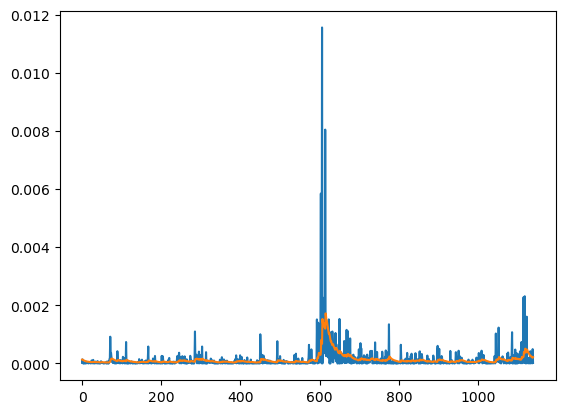

4.902149020176632e-07


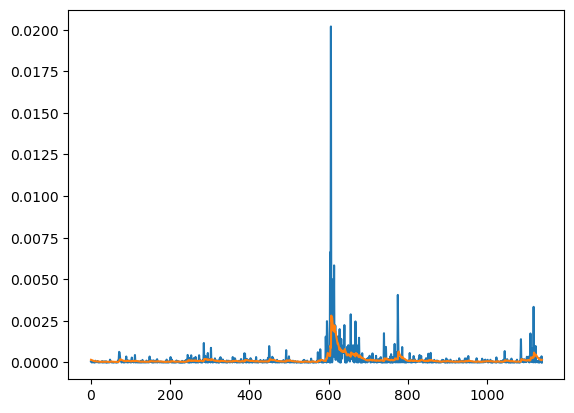

4.431777122911268e-07


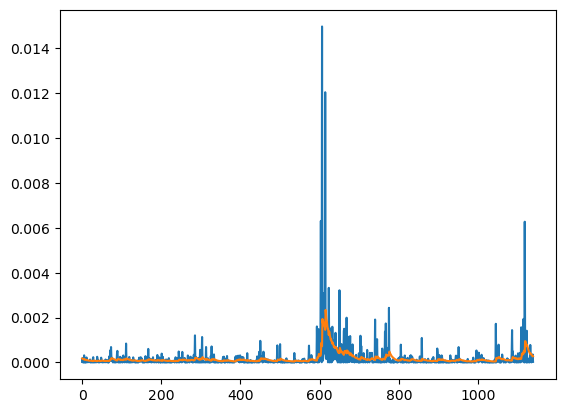

In [63]:
#plt.plot(vNpReturns[0,:]*vNpReturns[2,:])
for i in range(3):
    plt.plot(vTest[i,:]**2)
    plt.plot(mSigma_t_DCC[i,i,:])
    plt.show()
    print(mean_squared_error(vTest[i,:]**2, mSigma_t_DCC[i,i,:]))

# BEKK Model 

We basically want to optimise the following: 
$$\Sigma_t = (ii' -  aa' - bb')\odot \bar{\Sigma} + A_1' y_{t-1} A_1 + B_1'\Sigma_{t-1}B_1 $$

In [ ]:
def fnBEKKOneStep(vPar, mData):
    iN = mData.shape[0]
    iT = mData.shape[1]
    mOnes = np.ones((iN, iN))
    mA = np.diag(vPar[0:0+3])
    mB = np.diag(vPar[0+3:0+6])
    vA_diag = mA.diagonal()
    vB_diag = mB.diagonal()
    vSigma_bar = np.sum(fnMultiTimeDimVectorRightTranspose(mData, mData)) / iT
    mYY = fnMultiTimeDimVectorRightTranspose(mData, mData)
    mSigma_t = np.zeros((iN, iN, iT))
    mSigma_t[:,:,0] = vSigma_bar
    mOmega = (mOnes @ mOnes.T - vA_diag @ vA_diag.T - vB_diag @ vB_diag.T) * vSigma_bar
    #mOmega = np.array([[vPar[0], 0 , 0], [vPar[3], vPar[4], 0],  [vPar[6], vPar[7], vPar[8]]]) @ np.array([[vPar[0], vPar[1] , vPar[2]], [0, vPar[4], vPar[5]],  [0, 0, vPar[8]]])
    dLL = 0
    for t in range(1,iT):
        mSigma_t[:,:,t] = mOmega + mA @ mYY[:,:,t-1] @ mA + mB @ mSigma_t[:,:,t-1] @ mB
        dLL += iN*np.log(2*np.pi) + np.log(np.linalg.det(mSigma_t[:,:,t])) + mData[:,t].transpose() @ np.linalg.inv(mSigma_t[:,:,t]) @ mData[:,t]
    dLL = -0.5 * dLL
    # print(dLL)
    return -dLL

In [39]:
vIni = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
#vIni = [0.04, 0.17, 0.13, 0.11, 0.11, 0.097, 0.08, 0.06, 0.007, 0.118, 0.0777, 0.126, 0.11,  0.11, 0.097 ]
vResults_BEKK = minimize(fnBEKKOneStep, vIni, args = vTrain, method = 'Nelder-Mead')

C:\Users\onim-\AppData\Local\Temp\ipykernel_22260\1183599160.py:18: RuntimeWarning: invalid value encountered in log
  dLL += iN*np.log(2*np.pi) + np.log(np.linalg.det(mSigma_t[:,:,t])) + mData[:,t].transpose() @ np.linalg.inv(mSigma_t[:,:,t]) @ mData[:,t]


nan
nan
nan
nan
-8742769.024613876
-12961465.395756865
-12959031.303379707
nan
nan
-21473226.244634762
-23476406.638265867
-15055098.163378797
-15341564.46667498
-15062854.33258231
-16351785.580641193
-11232254.46962734
-11349697.007062221
-13317733.50148382
-12985649.036713218
-11781630.837771248
-8657501.581206143
-6706239.174627923
-11348195.842314918
-15279449.669034569
-16615100.311445024
-9315939.220416736
-9099274.20534604
-11633003.658503179
-8769009.70091982
-7968593.22359253
-10850735.24742625
-8098973.630998508
-7225188.484229148
-8311881.300223033
-7387377.313124832
-8528392.824987048
-6720578.349513108
-10713442.237639029
-7207189.010599275
-10626245.07956769
-8498462.060661083
-6404462.3526909305
-6935941.704857145
-6543976.621017762
-10511286.082199125
-6529825.052655273
-8722659.870189045
-7303640.051293829
-7620974.261876075
-7458550.621723075
-6850891.696366898
-10170033.967147456
-7797834.953959948
-6711265.977285062
-6922128.663046049
-6474097.925457007
-6558018.441

In [42]:
vResults_BEKK

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -43537.4224053304
             x: [ 8.961e-01  4.357e-01  9.782e-01 -2.698e-01 -7.963e-01
                 -5.318e-01]
           nit: 456
          nfev: 762
 final_simplex: (array([[ 8.961e-01,  4.357e-01, ..., -7.963e-01,
                        -5.318e-01],
                       [ 8.961e-01,  4.357e-01, ..., -7.964e-01,
                        -5.318e-01],
                       ...,
                       [ 8.961e-01,  4.357e-01, ..., -7.964e-01,
                        -5.318e-01],
                       [ 8.961e-01,  4.357e-01, ..., -7.964e-01,
                        -5.318e-01]]), array([-4.354e+04, -4.354e+04, -4.354e+04, -4.354e+04,
                       -4.354e+04, -4.354e+04, -4.354e+04]))

In [41]:
vResults_BEKK.x

array([ 0.89608316,  0.43565624,  0.97819279, -0.26981313, -0.79634411,
       -0.53179857])

# ADCC Model

In [43]:
def fnADCCOneStep(vPar, mData):
    iN = mData.shape[0]
    iT = mData.shape[1]
    mDt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mSigt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mR = np.identity(mData.shape[0])
    mS = 0
    mN = 0
    mEpsilon2 = np.zeros(mSigmat.shape)
    mN2 = np.zeros(mSigmat.shape)
    p = 0
    for i in range(iN):
        mDt[i, i, :] = np.sqrt(fnGJR_garch(vPar[i*4 : (i+1)*4], mData[i, :]))
    
    vEpsilon = np.zeros((mDt.shape[1], 1, mDt.shape[2]))
    vN_t = np.zeros((mDt.shape[1], 1, mDt.shape[2]))
    for t in range(iT):
        vEpsilon[:,:,t] = np.reshape(np.linalg.inv(mDt[:,:,t]) @ mData[:,t], (iN,1)) 
        bCondition = vEpsilon[:,:,t] < 0 
        vN = (bCondition + np.zeros((iN,1)) ) * vEpsilon[:,:,t]
        mN2[:,:,t] = vN @ vN.T
        mN += vN @ vN.T
        mS += vEpsilon[:,:,t] @ vEpsilon[:,:,t].transpose()
        mEpsilon2[:,:,t] = vEpsilon[:,:,t] @ vEpsilon[:,:,t].transpose()

    mN_bar = mN / iT
    mS = mS / iT

    dA = vPar[iN*4]
    dB = vPar[iN*4 +1 ]
    dG = vPar[iN*4 +2 ]
    dW = (1-dA-dB)

    mQ = np.zeros( (vEpsilon.shape[0], vEpsilon.shape[0], vEpsilon.shape[2]) )
    mQ[:,:,0] = np.cov(vEpsilon.reshape(iN,vEpsilon.shape[2]))
    k = iN
    dLL1 = 0 
    dLL2 = 0
    for t in range(iT):
        mQ[:,:,t] = dW * mS + dG * mN_bar +dA * (vEpsilon[:,:,t-1] @ vEpsilon[:,:,t-1].transpose()) + dB * mQ[:,:,t-1] + dG * mN2[:,:,t-1]
        mRt = np.linalg.inv(np.sqrt(np.diag(np.diag(mQ[:,:,t])))) @ mQ[:,:,t] @ np.linalg.inv(np.sqrt(np.diag(np.diag(mQ[:,:,t]))))
        dLL1 += k*np.log(2 * np.pi) + 2*np.log(np.linalg.det(mDt[:,:,t])) + (vEpsilon[:,:,t].transpose() @ vEpsilon[:,:,t])
        dLL2 += np.log(np.linalg.det(mRt)) + vEpsilon[:,:,t].transpose() @ np.linalg.inv(mRt) @ vEpsilon[:,:,t] - vEpsilon[:,:,t].transpose()@vEpsilon[:,:,t]
    dLL = -0.5*dLL1 -0.5*dLL2
    # print(dLL[0][0])
    return -dLL[0][0]

In [44]:
bounds = [(0.000001, 20), (0.00000001, 0.99999999), (0.00000001, 0.99999999), (0,2)]*3 + [(0.000000001, 0.99999999)]*3
vIni = [np.var(vNpReturns[0,:])*(1-0.15-0.30), 0.15, 0.30, 0.2, np.var(vNpReturns[1,:])*(1-0.15-0.25), 0.15, 0.25, 0.2,  np.var(vNpReturns[2,:])*(1-0.35-0.15), 0.35, 0.15, 0.2, 0.3, 0.3, 0.3]
options = {'maxiter': 10000, 'xatol': 1e-3}
#options = {'eps' : 1e-11, 'ftol': 1e-5}
results_ADCC = minimize(fnADCCOneStep, vIni, args= vTrain, bounds = bounds, method= "Nelder-Mead", options=options)

In [ ]:
fnADCCOneStep([np.var(vNpReturns[0,:])*(1-0.15-0.30), 0.15, 0.30, np.var(vNpReturns[1,:])*(1-0.15-0.25), 0.15, 0.25, np.var(vNpReturns[2,:])*(1-0.35-0.15), 0.35, 0.15, 0.3, 0.3, 0.3], vNpReturns)

In [46]:
results_ADCC.x

array([1.74635967e-06, 8.80985340e-02, 8.96858660e-01, 4.49348914e-03,
       2.04463404e-06, 4.35308427e-02, 9.03321421e-01, 7.02840818e-02,
       2.03702016e-06, 5.70236169e-02, 9.14349295e-01, 3.01270657e-02,
       2.79941998e-02, 9.62729306e-01, 5.02970953e-07])

array([6.43098120e-06, 1.00782815e-01, 8.58385789e-01, 4.94600663e-06,
       1.02049287e-01, 8.60655308e-01, 6.07012373e-05, 7.09083078e-01,
       2.90059892e-01, 8.36809943e-01, 8.59071380e-01, 7.72184067e-01])